In [1]:
import tensorflow as tf
# from tensorflow.keras import models, layers => error version
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS= 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PlantVillage-Tomato",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 16011 files belonging to 10 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-21 18:41:24.962381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 18:41:24.962985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
len(dataset)

501

In [6]:
32*501

16032

In [15]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [39]:
len(class_names)

10

In [16]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

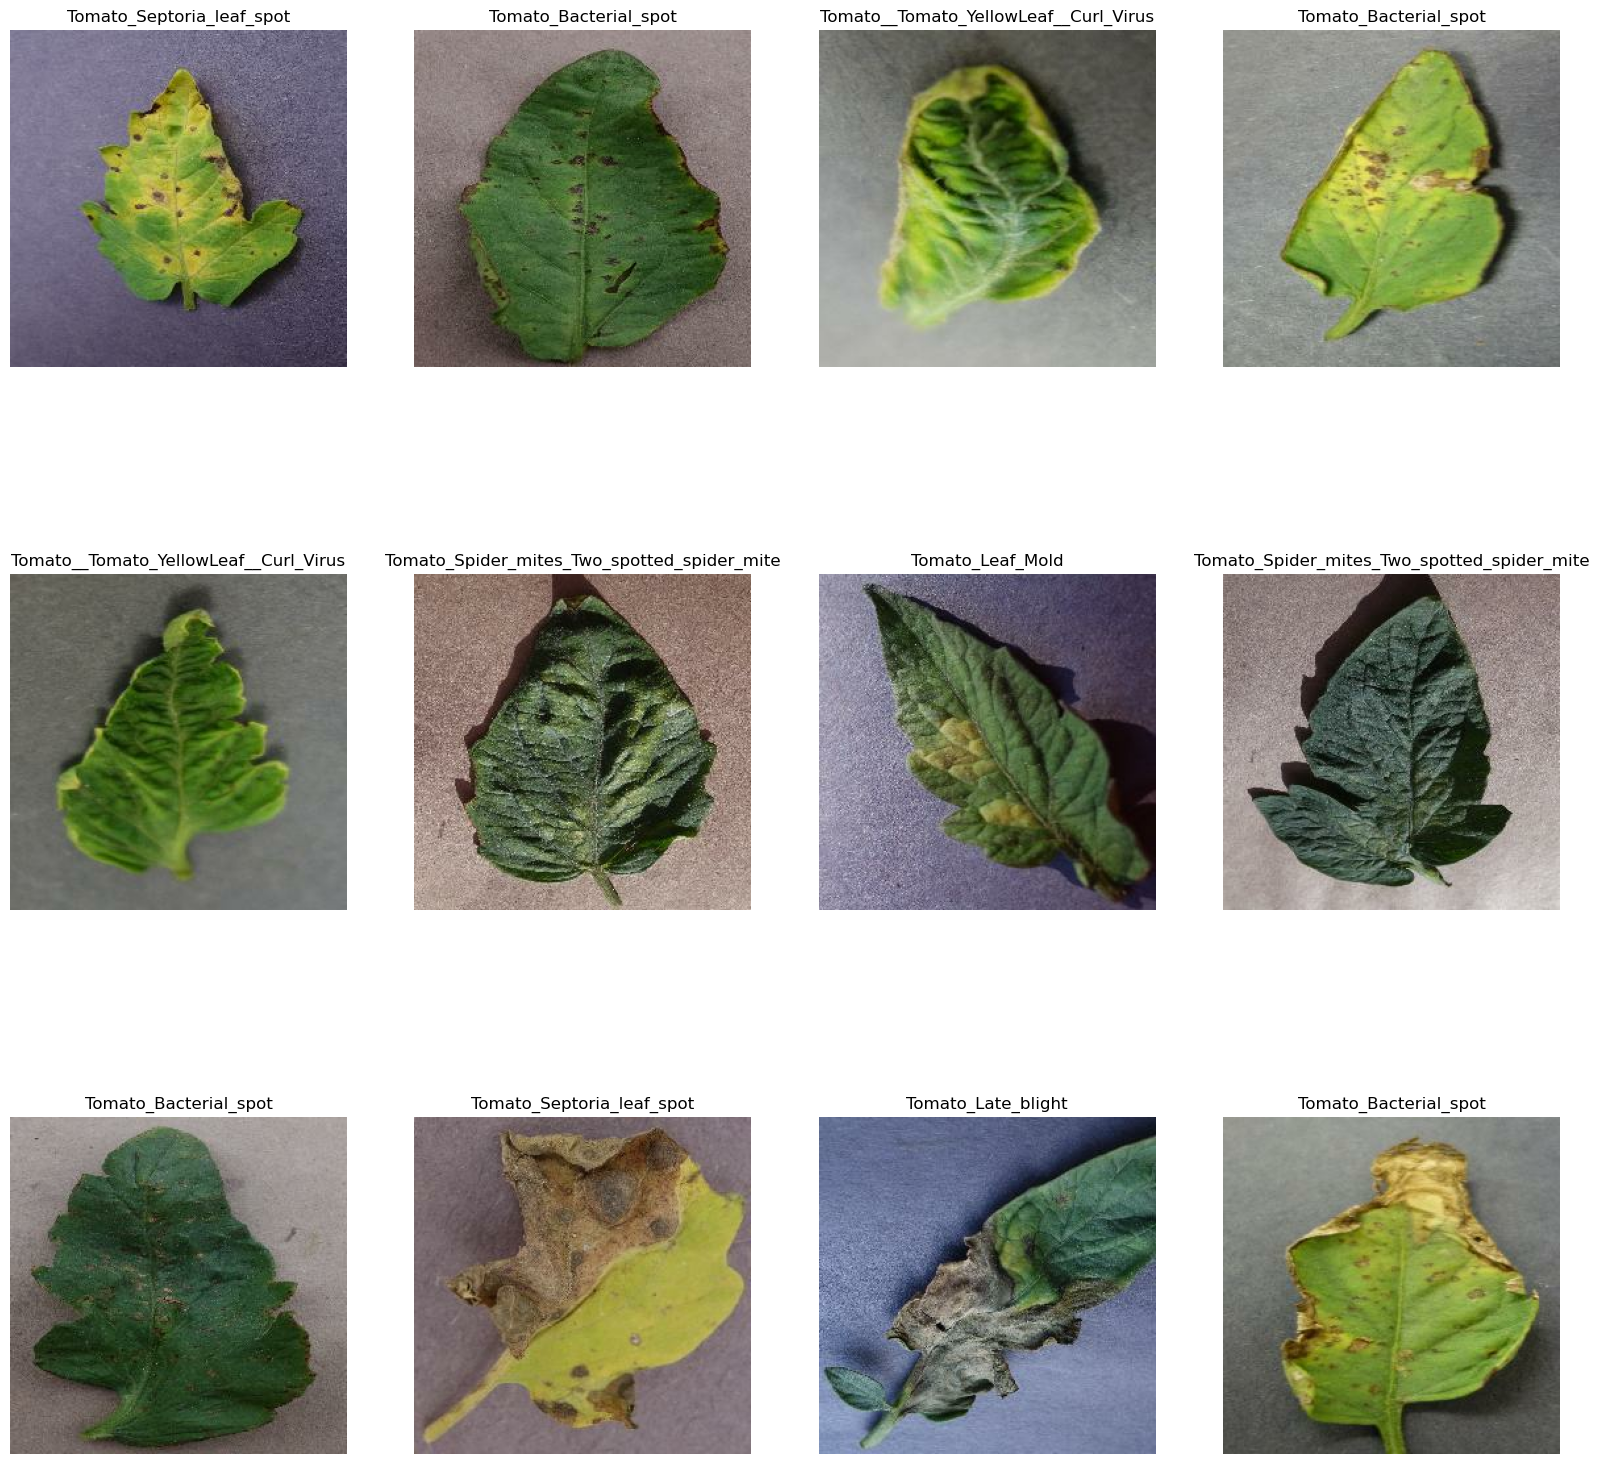

In [19]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax =plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

80% ==> training


20% ==> 10% validation & 10% test

In [21]:
train_size = 0.8
len(dataset) * train_size

400.8

In [22]:
train_ds = dataset.take(400)

In [23]:
test_ds=dataset.skip(400)
len(test_ds)

101

In [24]:
val_size = 0.1
len(dataset) * val_size

50.1

In [25]:
val_ds= test_ds.take(50)
len(val_ds)

50

In [26]:
test_ds = test_ds.skip(50)
len(test_ds)

51

In [27]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000  ):
  ds_size =len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds= get_dataset_partitions_tf(dataset)

In [29]:
len(train_ds)

400

In [30]:
len(val_ds)

50

In [31]:
len(test_ds)

51

In [32]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
resize_and_rescale = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [35]:
data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [40]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape=input_shape)

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [42]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

In [43]:
history=model.fit(
  train_ds,
  epochs=EPOCHS,
  batch_size= BATCH_SIZE,
  verbose=1,
  validation_data=val_ds
)

Epoch 1/40


2023-01-23 21:05:56.566044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-23 21:06:06.813343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 472 of 10000
2023-01-23 21:06:07.422708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-01-23 21:06:07.429032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-01-23 21:06:07.589930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


400/400 [==============================] - ETA: 0s - loss: 1.5059 - accuracy: 0.4579

2023-01-23 21:09:53.808338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 250s 588ms/step - loss: 1.5059 - accuracy: 0.4579 - val_loss: 1.0905 - val_accuracy: 0.6281
Epoch 2/40
400/400 [==============================] - 202s 504ms/step - loss: 0.8299 - accuracy: 0.7069 - val_loss: 0.9220 - val_accuracy: 0.6819
Epoch 3/40
400/400 [==============================] - 216s 540ms/step - loss: 0.5878 - accuracy: 0.7971 - val_loss: 0.8341 - val_accuracy: 0.7362
Epoch 4/40
275/400 [===================>..........] - ETA: 1:05 - loss: 0.4524 - accuracy: 0.8408

KeyboardInterrupt: 